
## Meuse Spatial Autocorrelation

This notebook shows, step by step, how to:
1. Load the classic **Meuse** dataset (keep `x`, `y`, heavy metals like `zinc`).
2. Turn it into a **GeoDataFrame** and confirm a **metric CRS**.
3. Run a **global spatial autocorrelation test** (Moran's I) on a target metal (e.g., zinc).
4. Build and interpret a **semivariogram** with **SciKit-GStat**.
5. Create **permutation envelopes** for the experimental variogram (is structure beyond random?).
6. **Cross-validate** the variogram/kriging against a non-spatial baseline.
7. **Interpolate** concentrations across the study area via **Ordinary Kriging**.

> Dataset: `meuse.csv` with coordinates `x`, `y` (meters; RD New, EPSG:28992) and variables like `zinc`, `lead`, `copper`, `cadmium`, `elev`, `dist`, etc.  
> Source: https://github.com/filipkral/meuse/tree/master

## Meuse data dictionary (selected fields)

- x, y (meters): Dutch RD New projected coordinates (EPSG:28992)
- zinc (mg/kg, ppm): zinc concentration in topsoil
- lead (mg/kg, ppm): lead concentration in topsoil
- copper (mg/kg, ppm): copper concentration in topsoil
- cadmium (mg/kg, ppm): cadmium concentration in topsoil
- elev (m): elevation
- dist (m): distance to River Meuse
- om (%): organic matter fraction

Source: Meuse dataset (see repository link above). Units reflect standard geochemical reporting.

### Recap: Semivariance and the empirical variogram

Semivariance at lag $h$ measures how different two locations tend to be when they are about distance $h$ apart. A compact, memory-friendly way to say this:

- Pick many pairs of locations that are about distance $h$ apart.
- For each pair compute the difference in the measured value, square it, and then average those squared differences across pairs.
- Semivariance is half of that average.

In symbols (empirical semivariogram):

$$
\hat{\gamma}(h) = \frac{1}{2 |N(h)|} \sum_{(i,j) \in N(h)} \left[z(s_i) - z(s_j)\right]^2
$$

Here $N(h)$ is the set of sample pairs whose separation is approximately $h$ (within a tolerance). Note: we average squared differences, then divide by two.

Why the "half"? For a stationary process the variance of the difference between two points equals twice the process variance minus twice the covariance at lag $h$:

$$
\mathrm{Var}[Z(s+h)-Z(s)] = 2(\sigma^2 - \mathrm{Cov}(h))
$$

Dividing by 2 gives the semivariance $\gamma(h) = \sigma^2 - \mathrm{Cov}(h) = \sigma^2 (1 - \rho(h))$, which ties semivariance directly to correlation $\rho(h)$.

**Intuition and quick implications**

- Small $h$: nearby points tend to be similar $\rightarrow$ small squared differences $\rightarrow$ small semivariance.
- Large $h$: similarity fades $\rightarrow$ semivariance grows and (for large $h$) approaches the process variance (the sill).
- Nugget (value near $h \approx 0$): any nonzero intercept reflects measurement error and/or micro-scale variability (structure that exists at scales smaller than your sampling resolution).

Practical note: we rarely have pairs at exactly $h = 0$, so the nugget is an estimated intercept obtained when you fit a theoretical model to the empirical points (see below). The empirical points are computed from binned distances, then a parametric model (spherical/exponential/gaussian/Matern) is fit to those points and returns nugget, sill and range.

### Nugget estimation, and best practices (short)

**Nugget — intuitive and computational**

- Intuition: the nugget is the "noise floor" of your data — measurement error + micro-scale heterogeneity.
- Computationally: you estimate the nugget by fitting a theoretical variogram model to the empirical semivariogram points. The model intercept at $h = 0$ is the nugget estimate.

**Best practices**

- Choose sensible lag bins (enough pairs per bin); avoid bins with very few pairs.
- Visually inspect empirical points near the origin to see evidence of a nugget.
- Fit more than one model family and compare; use cross-validation diagnostics (kriging CV) to check model choice.
- If your spatial extent is small relative to the true correlation range, you may never reach the sill; interpret parameters cautiously.

In [1]:
# Required libraries for spatial analysis and geostatistics
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point, Polygon
from libpysal.weights import KNN
from esda.moran import Moran
import gstools as gs
from scipy.spatial.distance import pdist
import skgstat as skg


# Use inline matplotlib backend for notebook visualization
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## 1) Load & inspect the Meuse data

We select core fields and choose `zinc` as the working response (you can switch to `lead`, `copper`, etc.). Coordinates `x`, `y` are already in meters (Dutch RD New).

In [2]:
# Path to meuse dataset (adjust if stored elsewhere)
CSV_PATH = "data/meuse/meuse.csv"  # expectation: columns x,y,zinc,lead,copper,cadmium,elev,dist,om

df = pd.read_csv(CSV_PATH)
expected_cols = {"x","y","zinc"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Keep essential columns (can extend as needed)
cols_keep = [c for c in ["x","y","zinc","lead","copper","cadmium","elev","dist","om"] if c in df.columns]
df = df[cols_keep].copy()
df.head()

,x,y,zinc,lead,copper,cadmium,elev,dist,om
0,181072,333611,1022,299,85,11.7,7.909,0.001358,13.6
1,181025,333558,1141,277,81,8.6,6.983,0.012224,14.0
2,181165,333537,640,199,68,6.5,7.800,0.103029,13.0
3,181298,333484,257,116,81,2.6,7.655,0.190094,8.0
4,181307,333330,269,117,48,2.8,7.480,0.277090,8.7



## 2) Basic cleaning & response setup

Unlike Airbnb prices, Meuse metal concentrations are already numeric. We will:
- Drop rows with missing coordinates or target values.
- Optionally log-transform `zinc` to reduce skew (common in geochemistry); if you do, apply the transform explicitly before running the variogram/kriging cells.

In [3]:
# Target variable (easily switch to 'lead','copper','cadmium')
TARGET = 'zinc'
assert TARGET in df.columns, f"Target {TARGET} not found."

# Drop missing
df = df.dropna(subset=["x","y",TARGET]).copy()

# Optionally log-transform the target: set LOG_TRANSFORM = True to apply a natural log to the target.
# We save an untransformed copy in case you need it for back-transformation or diagnostics.
LOG_TRANSFORM = True  # set to False to keep original scale
if LOG_TRANSFORM:
    df[f"{TARGET}_orig"] = df[TARGET]  # keep original values
    # Clip small/zero values to avoid -inf on log; choose a small positive lower bound
    lower = 1e-6
    df[TARGET] = np.log(df[TARGET].clip(lower=lower))
    print("Applied natural log transform to target (saved original in {TARGET}_orig).")

print("Rows after cleaning:", len(df))
df.describe()[[TARGET]]

Applied natural log transform to target (saved original in {TARGET}_orig).
Rows after cleaning: 155


,zinc
count,155.000000
mean,5.885776
std,0.721881
min,4.727388
25%,5.288267
50%,5.786897
75%,6.513969
max,7.516977



## 3) GeoDataFrame & CRS

Meuse coordinates (`x`,`y`) are already in meters (Amersfoort / RD New, EPSG:28992). We build a GeoDataFrame and verify projection.

In [4]:
# Construct GeoDataFrame (coordinates already metric)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:28992")

coords = np.column_stack([gdf.geometry.x, gdf.geometry.y]).astype("float64")
values = gdf[TARGET].to_numpy(dtype="float64")

print("CRS:", gdf.crs)
print("Coordinate sample (m):", coords[:3])
print("Value sample:", values[:3])

CRS: EPSG:28992
Coordinate sample (m): [[181072. 333611.]
 [181025. 333558.]
 [181165. 333537.]]
Value sample: [6.92951677 7.03966035 6.46146818]



## 4) Global spatial autocorrelation: Moran's I

We build a k-nearest neighbors graph (k=8) and test spatial autocorrelation for the target metal.

<Axes: xlabel='x', ylabel='y'>

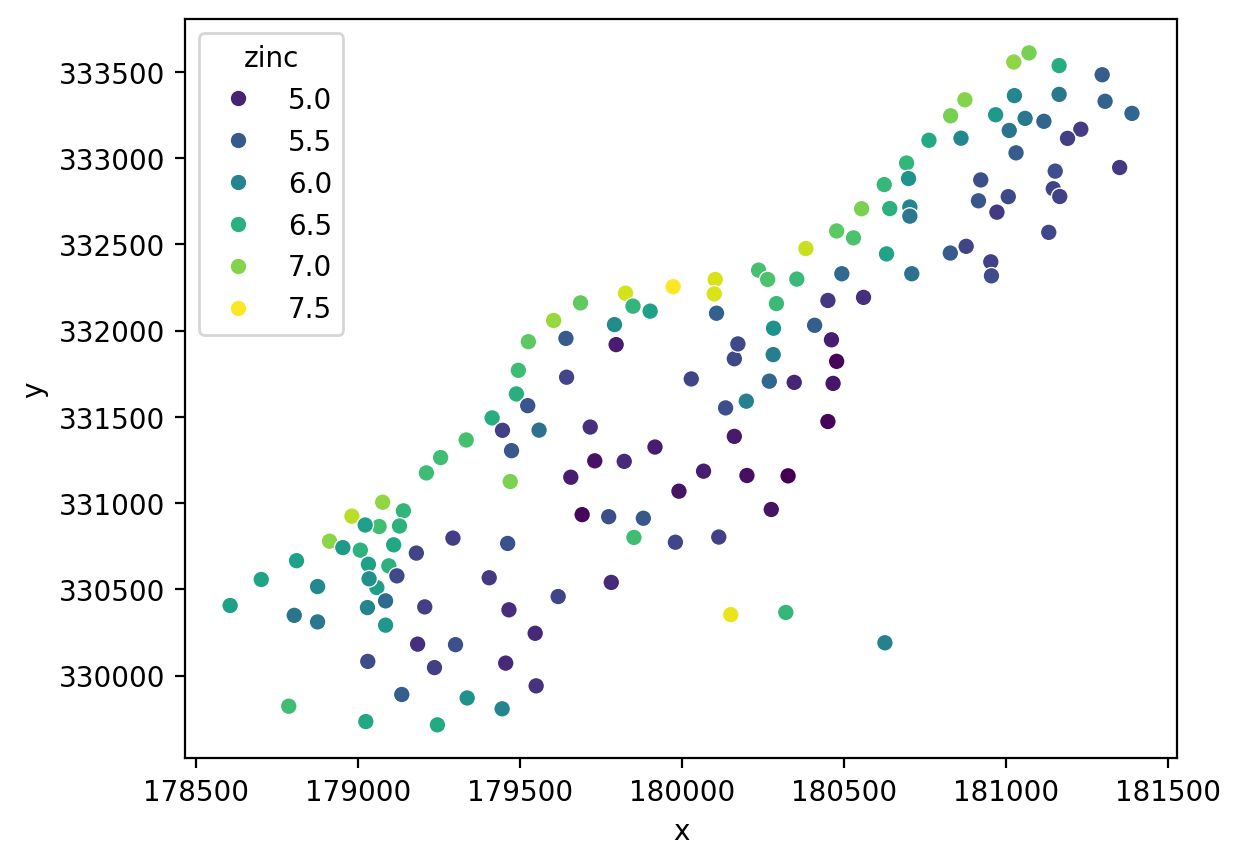

In [5]:
sns.scatterplot(data=gdf, x='x', y='y', hue=TARGET, palette='viridis')

In [6]:

# Build a KNN weights matrix (ensure graph is connected by tuning k if needed)
k = 8
w = KNN.from_array(coords, k=k)
w.transform = "r"  # row-standardize weights

mi = Moran(values, w, permutations=999)
print(f"Moran's I = {mi.I:.4f}   p-value = {mi.p_sim:.4f}   (k={k})")


Moran's I = 0.4896   p-value = 0.0010   (k=8)



**Interpretation**  
- Significant positive I → clustered similar concentrations (e.g., elevated zinc zones).  
- Non-significant → no global spatial autocorrelation at the chosen neighbor scale.  
- Negative (rare here) → spatial repulsion / checkerboard pattern.


## 5) Semivariogram

We examine how semivariance grows with distance; fit a model for kriging.

In [7]:
n_lags = 16

# Build variogram
V = skg.Variogram(
    coordinates=coords,
    values=values,
    model='gaussian',
    n_lags=n_lags,
    maxlag='median',
    use_nugget=True,
    estimator='cressie'
 )

print("Variogram built:", V.model.__name__, "n_lags=", V.n_lags, "maxlag=", V.maxlag)

Variogram built: gaussian n_lags= 16 maxlag= 1372.6660191029719


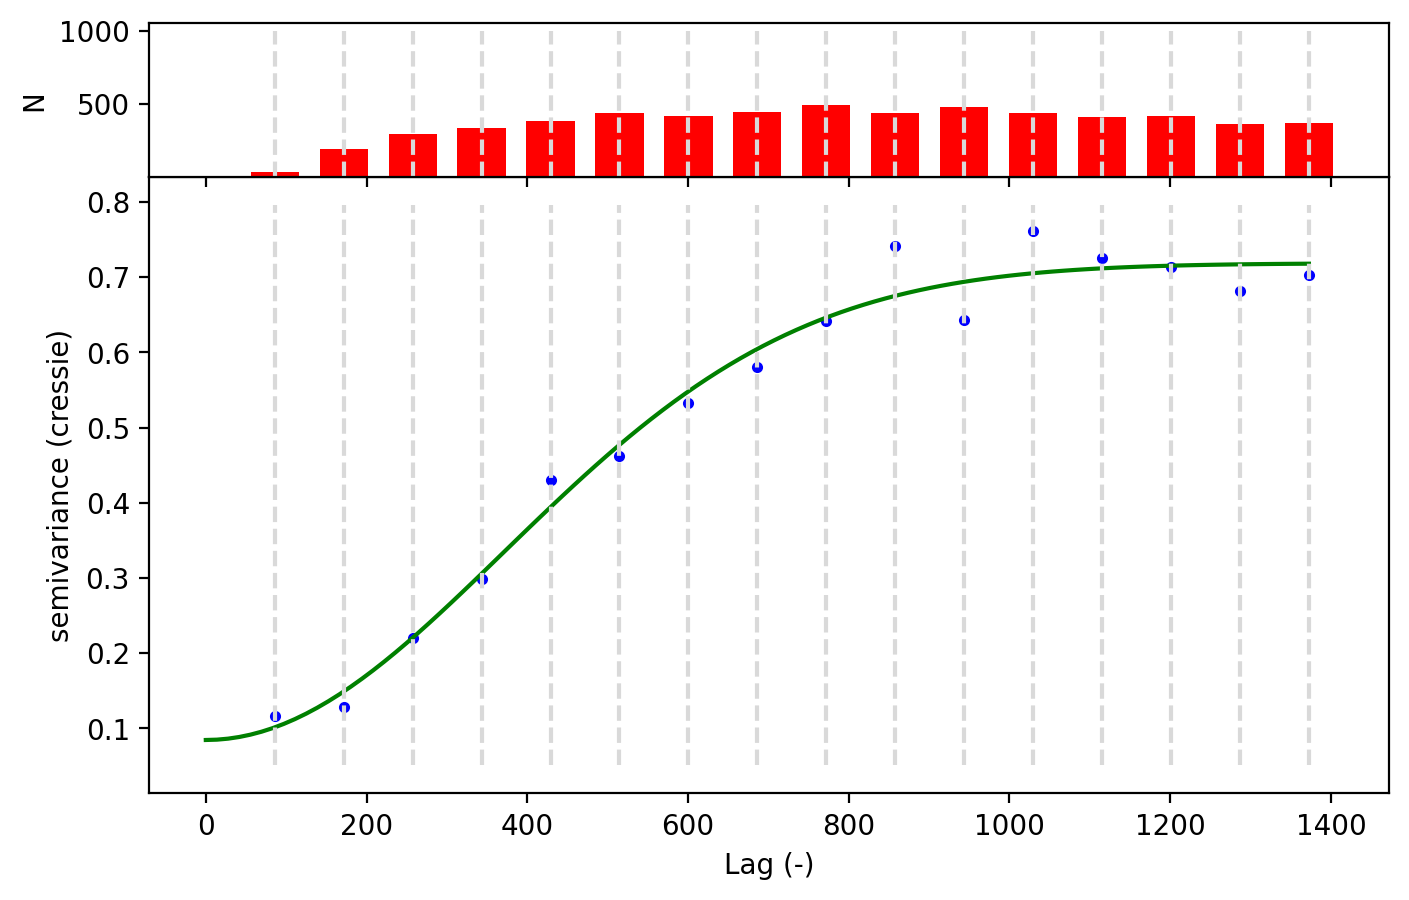

In [8]:
_plot = V.plot()

In [9]:
params = V.describe()
params

{'model': 'gaussian',
 'estimator': 'cressie',
 'dist_func': 'euclidean',
 'normalized_effective_range': np.float64(1438509.808750984),
 'normalized_sill': np.float64(0.48297041802202406),
 'normalized_nugget': np.float64(0.0643836205805433),
 'effective_range': np.float64(1047.9678149904523),
 'sill': np.float64(0.6341332954688785),
 'nugget': np.float64(0.0845347788797616),
 'params': {'estimator': 'cressie',
  'model': 'gaussian',
  'dist_func': 'euclidean',
  'bin_func': 'even',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': np.float64(1372.6660191029719),
  'n_lags': 16,
  'verbose': False},
 'kwargs': {}}

In [10]:
h = V.bins
expv = V.experimental

fit_fn = V.fitted_model
y_fit = fit_fn(h)

nugget = params["nugget"]
sill = params["sill"]
range = params["effective_range"]

print({"nugget": nugget, "sill": sill, "range": range})

{'nugget': np.float64(0.0845347788797616), 'sill': np.float64(0.6341332954688785), 'range': np.float64(1047.9678149904523)}


**How to read this**  
- **Nugget**: micro-scale variability + measurement noise (field sampling and lab).
- **Sill**: plateau ≈ total semivariance once spatial correlation vanishes.
- **Range**: distance where spatial influence fades; beyond it, additional distance adds little dissimilarity.

Example (Meuse):
- Nugget ≈ 0.08 → small micro-scale noise relative to the sill.
- Sill ≈ 0.70 → total variance for the property (e.g., zinc concentration).
- Range ≈ 800 (units) → spatial dependence extends roughly 800 units; beyond that, points are uncorrelated.
  
Nugget-to-sill ratio and practical meaning:
- Ratio = nugget / sill; values < 0.25 typically indicate strong spatial dependence (good for kriging).

> Note: We use a robust estimator (`cressie`) with 16 lags and `maxlag='median'` to emphasize short-range structure; tweak for different targets.

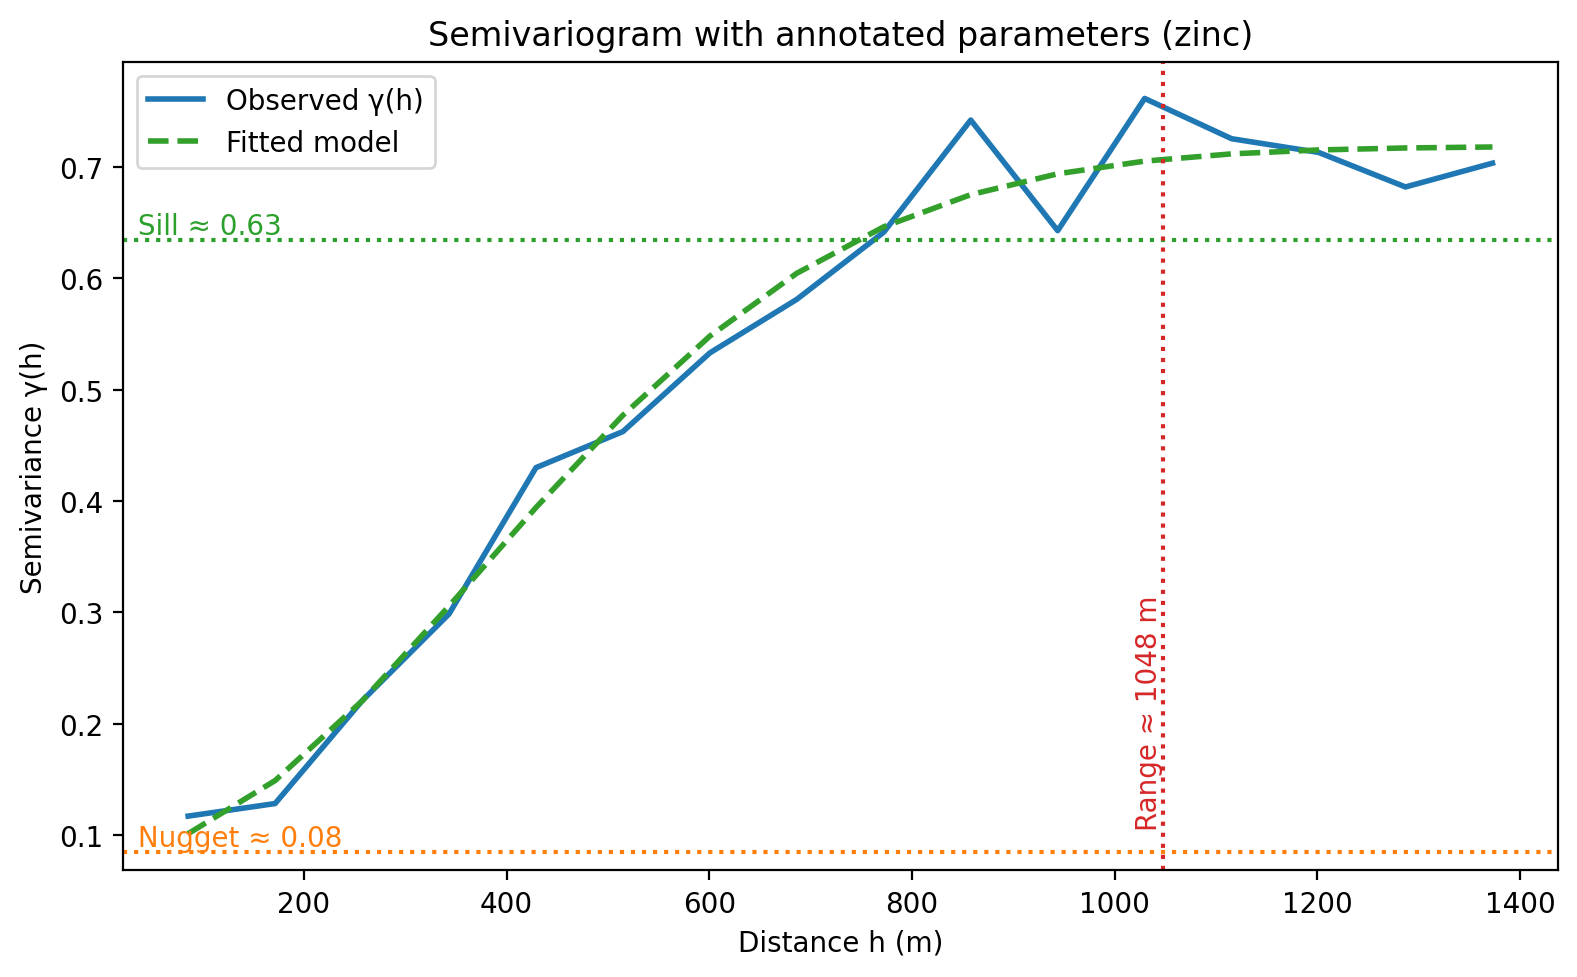

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(h, expv, label='Observed γ(h)', lw=2, color='#1f78b4')
ax.plot(h, y_fit, label='Fitted model', ls='--', lw=2, color='#33a02c')
ax.axhline(nugget, color='tab:orange', ls=':', lw=1.5)
ax.text(h.max()*0.02, nugget, f" Nugget ≈ {nugget:.2f}", va='bottom', color='tab:orange')
ax.axhline(sill, color='tab:green', ls=':', lw=1.5)
ax.text(h.max()*0.02, sill, f" Sill ≈ {sill:.2f}", va='bottom', color='tab:green')
ax.axvline(range, color='tab:red', ls=':', lw=1.5)
y0, y1 = ax.get_ylim()
ax.text(range, y0 + 0.05*(y1-y0), f"Range ≈ {range:.0f} m", rotation=90, va='bottom', ha='right', color='tab:red')
ax.set_xlabel('Distance h (m)')
ax.set_ylabel('Semivariance γ(h)')
ax.set_title(f'Semivariogram with annotated parameters ({TARGET})')
ax.legend(frameon=True)
plt.tight_layout()
plt.show()



### Compare variogram models by RMSE


> Model selection note: prefer CV error (prediction-focused) over pure variogram RMSE; confirm that chosen configuration yields early-lag structure consistent with envelopes.

In [12]:
candidates = ["spherical", "exponential", "gaussian", "stable", "matern"]
scores = {}
for m in candidates:
    
    V.set_model(m)
    V.fit(force=True)
    
    scores[m] = float(V.rmse)
    
scores

{'spherical': 0.03266350024319307,
 'exponential': 0.05990255027431278,
 'gaussian': 0.030524630277367112,
 'stable': 0.030524630277281865,
 'matern': 0.030818908222498158}


## 6) Structure beyond random? Permutation envelope

Shuffle target values across locations to form a null (no spatial structure) and compare the experimental semivariogram.

In [13]:
# Build permutation envelope (compute only)
from tqdm import trange
import numpy as np

n_sim = 99  # 99 for classroom speed; use 499/999 for publication-grade envelopes
sim_exp = []

for _ in trange(n_sim, desc="Permutations"):
    Vp = skg.Variogram(
        coordinates=coords,
        values=np.random.permutation(values),
        n_lags=V.n_lags,
        maxlag=V.maxlag,
        use_nugget=True,
        estimator=V.estimator
    )
    sim_exp.append(Vp.experimental)

sim_exp = np.vstack(sim_exp)
lo = np.percentile(sim_exp, 2.5, axis=0)
hi = np.percentile(sim_exp, 97.5, axis=0)
h = V.bins
obs = V.experimental
print("Envelope computed.")

Permutations: 100%|██████████| 99/99 [00:00<00:00, 333.13it/s]

Envelope computed.



**Interpretation**  
- Observed below lower band at short lags → nearby concentrations more similar than random (positive structure).
- Within band → cannot reject random allocation at those distances.
- Above band (rare here) → local repulsion / sharp contrasts.


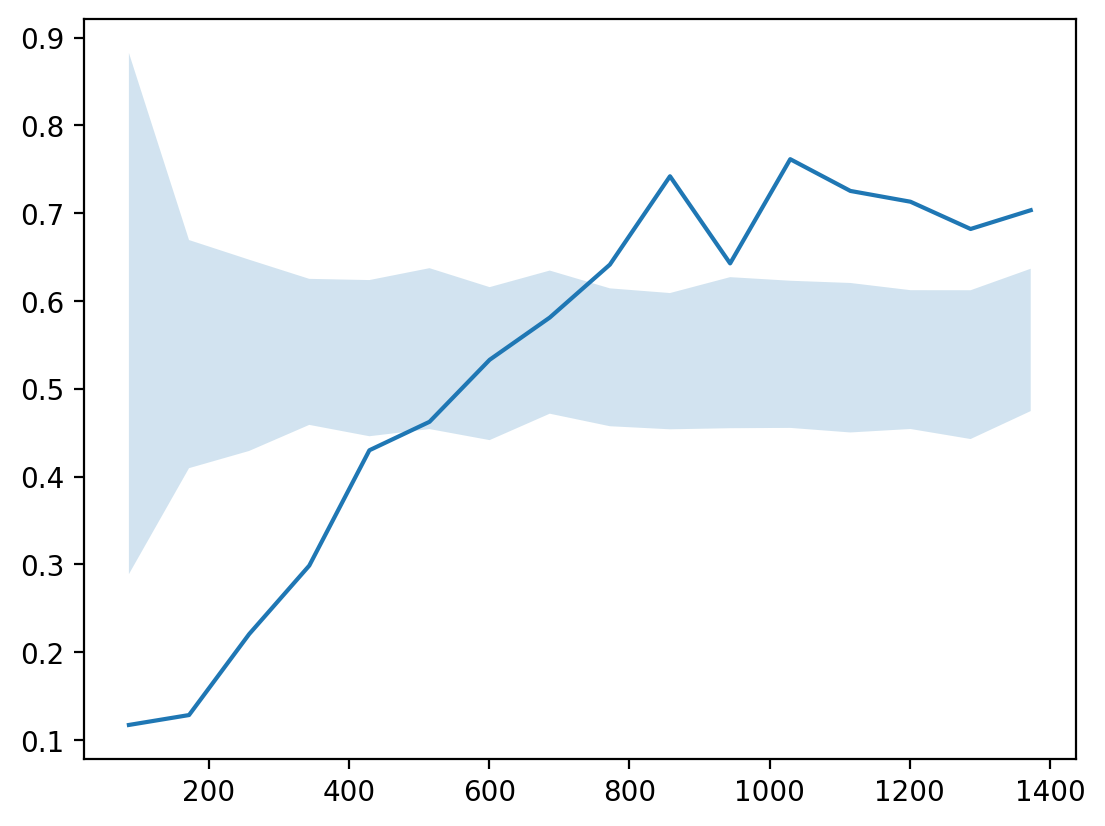

In [14]:
# Plot variogram with permutation envelope
plt.plot(h, obs)
plt.fill_between(h, lo, hi, alpha=0.2)


## 7) Predictive value: jackknife cross-validation vs global mean

In [15]:

# Baseline: always predict the global mean
ybar = values.mean()
baseline_rmse = np.sqrt(np.mean((values - ybar)**2))

# SciKit-GStat jackknife CV (uses kriging internally)
cv_rmse = V.cross_validate(method='jacknife', metric='rmse')

print(f"Baseline RMSE: {baseline_rmse:.3f}")
print(f"Kriging CV RMSE: {cv_rmse:.3f}")
improve = (baseline_rmse - cv_rmse) / baseline_rmse * 100
print(f"Relative improvement: {improve:.1f}%")


Baseline RMSE: 0.720
Kriging CV RMSE: 0.391
Relative improvement: 45.7%



Kriging RMSE < baseline mean RMSE → spatial dependence is predictively useful (not just statistically detectable).


## 8) Ordinary Kriging: interpolated concentration surface

We build a grid over the convex hull of sampling points (slightly buffered) and krige the target variable.

### Transformations and back-transforms (note)

If you choose to transform the target (for example, to reduce skew), do that explicitly before running the variogram and kriging cells and update the `values` array accordingly.

This notebook provides an optional natural-log transform in the data-cleaning cell: set `LOG_TRANSFORM = True` to apply `np.log` to the target. The original values are saved to `{TARGET}_orig` so you can back-transform predictions for interpretation.

If you do transform (e.g., log), remember that predictions produced on the transformed scale must be back-transformed for interpretation on the original scale; check the literature for appropriate bias-corrections when needed. Apply transforms and then re-run the variogram/kriging cells so derived objects (e.g., `V`, `ok`) reflect the transformed scale.

In [16]:
from skgstat import OrdinaryKriging

# Study window: convex hull of points buffered by small fraction of diagonal
hull = gdf.union_all().convex_hull
minx, miny, maxx, maxy = hull.bounds
diag = ((maxx - minx)**2 + (maxy - miny)**2) ** 0.5
buf = 0.001 * diag
window = hull.buffer(buf)

nx, ny = 50, 50
gx = np.linspace(minx - buf, maxx + buf, nx)
gy = np.linspace(miny - buf, maxy + buf, ny)
GX, GY = np.meshgrid(gx, gy)

ok = OrdinaryKriging(V, min_points = 3, mode='exact')
Z = ok.transform(GX.ravel(), GY.ravel()).reshape(ny, nx)

grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(GX.ravel(), GY.ravel()), crs=gdf.crs)
inside = grid_points.within(window).to_numpy().reshape(ny, nx)
Z_masked = np.where(inside, Z, np.nan)

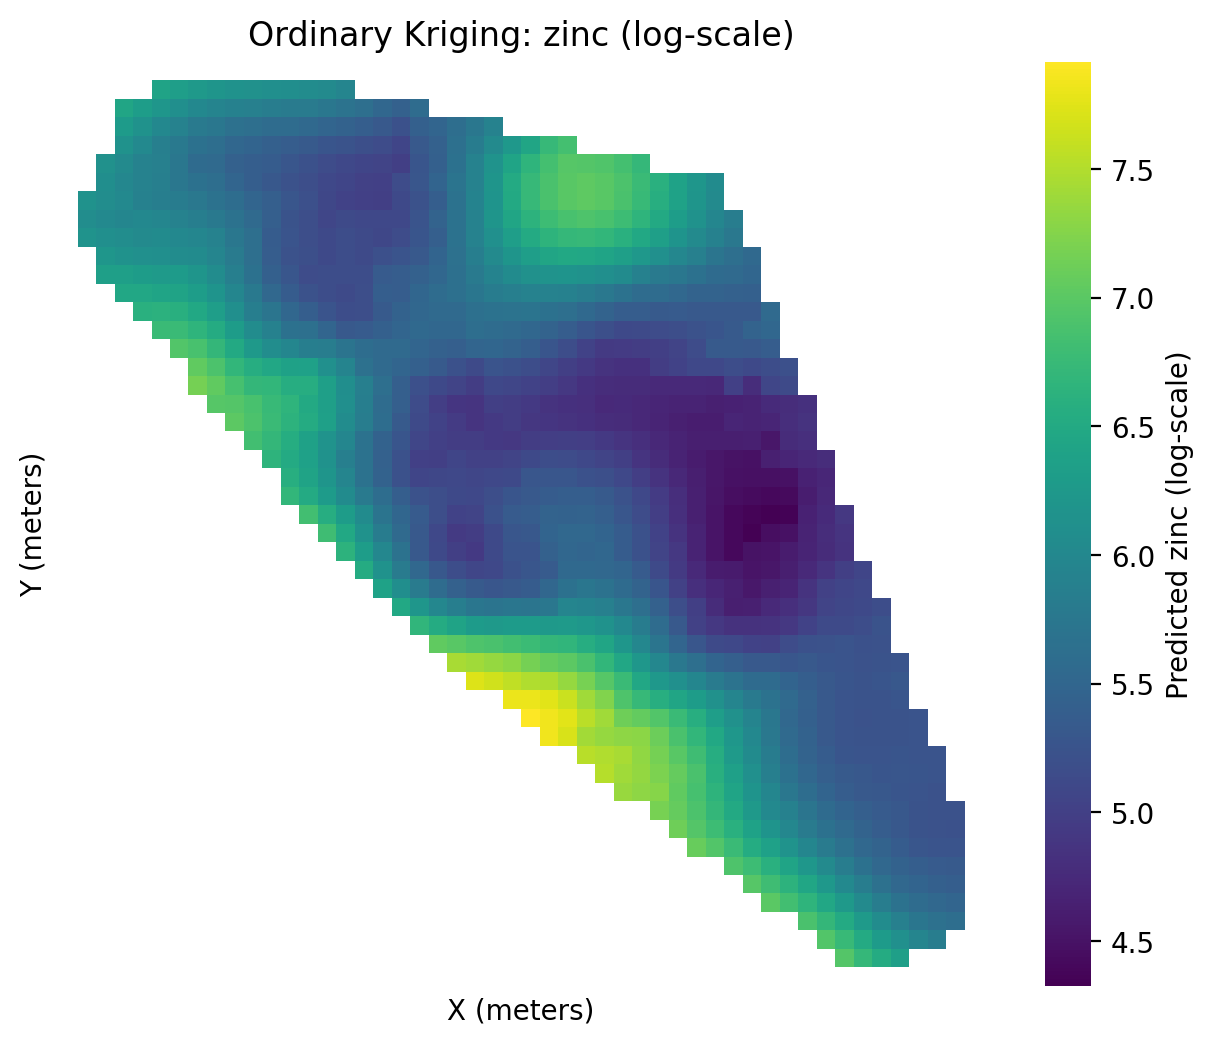

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(Z_masked, 
            cmap='viridis', 
            xticklabels=False, 
            yticklabels=False, 
            cbar_kws={'label': f'Predicted {TARGET} (log-scale)'})
plt.gca().set_aspect('equal')
gdf.plot(ax=plt.gca(), color='k', markersize=10, alpha=0.6)
plt.title(f'Ordinary Kriging: {TARGET} (log-scale)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.show()


## 9) Summary & next steps

- **Moran's I**: global test for spatial autocorrelation in heavy metal concentrations.
- **Semivariogram**: reveals range (continuity scale), nugget (micro-scale + noise), sill (total variance).
- **Permutation envelope**: confirms structure stronger than random allocation.
- **Cross-validation**: shows predictive gain of kriging vs naive mean.

### Best practices and tips

- Work in meters (Meuse already is).
- Check for skew; consider transforming heavy-tailed variables when justified (perform transformations explicitly before running the analysis).
- Inspect multiple metals: different processes → different ranges.
- Use permutation envelopes to avoid over-interpreting noise.
- Detrend with auxiliary variables (`elev`, `dist`, `om`) before modeling residual structure.
- Annotate nugget, sill, range for teaching clarity.
- Keep bin counts reasonable (10–18) and ensure ≥30 pairs per bin.